
IC mean=-0.0124, IR=-0.0741


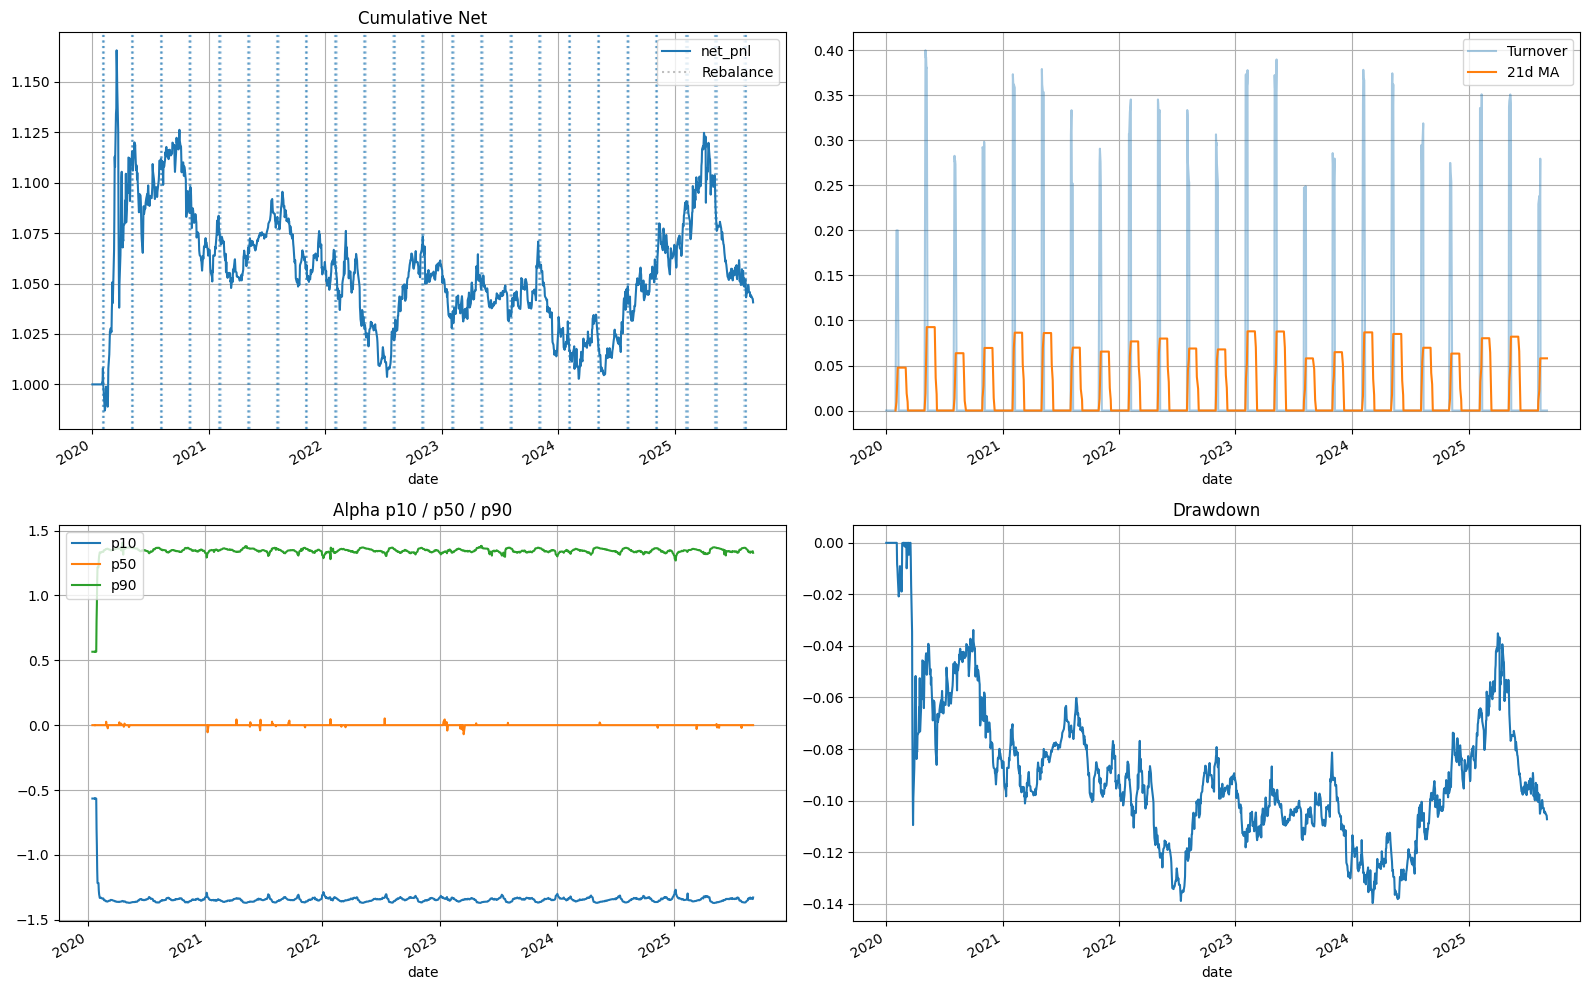

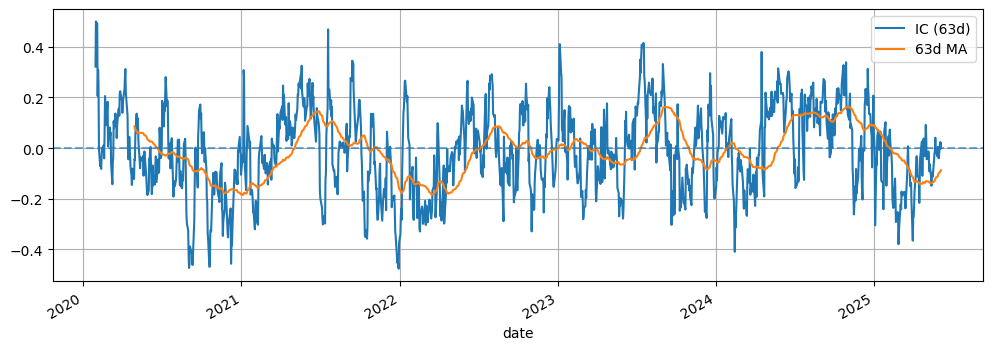

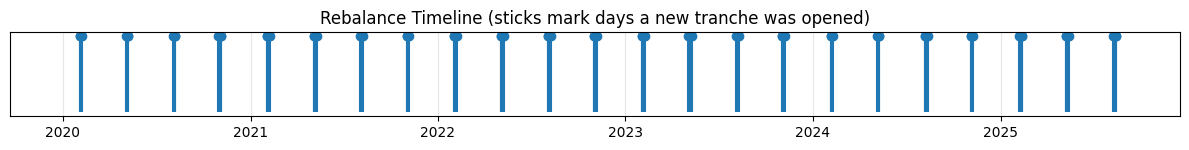


=== Performance ===
    Ann.Return:  0.0094
       Ann.Vol:  0.0681
        Sharpe:  0.1376
         MaxDD: -0.1397
        Calmar:  0.0671
  Total.Return:  0.0407
     Hit.Ratio:  0.4930

Entries: 58 | Avg daily gross: 0.965 (cap=1.0)
Rebalance days: 115

=== Costs ===
Avg daily turnover:  0.0250
Median daily turnover:0.0000
Avg daily cost (bps): 0.2501


In [ ]:
import warnings
from pathlib import Path
from typing import Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

warnings.filterwarnings("ignore")

# ---------------------------------------------------------------------------
# Paths and backtest parameters
# ---------------------------------------------------------------------------
MYPATH = "./"
ALPHA_WIDE_PARQUET = Path(f"{MYPATH}/OUTPUT/alpha_scores_event_daily_wide.parquet")
PRICE_PARQUET = Path(f"{MYPATH}/price_data/prices_3col_adjusted_2001_2025.parquet")

HOLD_PERIOD = 63
WINSOR_P = 0.01
TC_BPS = 10.0
RET_FREQ = 252
VOL_TARGET_ON = False
VOL_TARGET_ANNUAL = 0.10
VOL_TARGET_LOOKBACK = 63
GROSS_TARGET_DAILY = 1.0

def load_prices(price_parquet: Path) -> pd.DataFrame:
    df = pd.read_parquet(price_parquet)
    df = df.dropna(subset=["ticker", "date", "px"]).copy()
    df["date"] = pd.to_datetime(df["date"])
    df = df.drop_duplicates(subset=["date", "ticker"], keep="last")
    px = df.pivot(index="date", columns="ticker", values="px").sort_index()
    return px

def load_alpha(path: Path) -> pd.DataFrame:
    a = pd.read_parquet(path).copy()
    if {"date","ticker","alpha"}.issubset(a.columns):
        a["date"] = pd.to_datetime(a["date"])
        a = a.pivot(index="date", columns="ticker", values="alpha")
    elif "date" in a.columns:
        a["date"] = pd.to_datetime(a["date"]); a = a.set_index("date")
    else:
        a.index = pd.to_datetime(a.index)
    return a.sort_index()

def winsor_cs(df: pd.DataFrame, p=0.01) -> pd.DataFrame:
    lo, hi = df.quantile(p, axis=1), df.quantile(1-p, axis=1)
    return df.clip(lower=lo, upper=hi, axis=0)

def normalize_cs(a: pd.DataFrame, eps: float = 1e-9) -> pd.DataFrame:
    mu = a.mean(axis=1)
    sd = a.std(axis=1).replace(0, np.nan)
    return a.sub(mu, axis=0).div(sd + eps, axis=0)

def perf_stats(pnl: pd.Series, freq=252) -> Dict[str, float]:
    pnl = pnl.dropna()
    ann_ret, ann_vol = pnl.mean()*freq, pnl.std(ddof=0)*np.sqrt(freq)
    sharpe = ann_ret/ann_vol if ann_vol>0 else np.nan
    cum = (1+pnl).cumprod()
    dd = cum/cum.cummax()-1
    mdd = dd.min() if len(dd) else np.nan
    calmar = -ann_ret/mdd if (mdd is not None and mdd<0) else np.nan
    return {
        "Ann.Return": float(ann_ret),
        "Ann.Vol": float(ann_vol),
        "Sharpe": float(sharpe),
        "MaxDD": float(mdd),
        "Calmar": float(calmar),
        "Total.Return": float(cum.iloc[-1]-1) if len(cum) else np.nan,
        "Hit.Ratio": float((pnl>0).mean())
    }

def forward_returns(px: pd.DataFrame, h=63) -> pd.DataFrame:
    return px.shift(-h)/px.shift(-1)-1.0

def ic_series(alpha_raw: pd.DataFrame, px: pd.DataFrame, h=63) -> pd.Series:
    fwd = forward_returns(px, h)
    a, f = alpha_raw.align(fwd, join="inner", axis=0)
    vals = []
    for dt in a.index:
        x, y = a.loc[dt], f.loc[dt]
        m = x.notna() & y.notna()
        vals.append(spearmanr(x[m], y[m])[0] if m.sum()>=5 else np.nan)
    return pd.Series(vals, index=a.index, name=f"IC_{h}d")

def select_long_short(a_s: pd.Series,
                      top_q=0.2, bot_q=0.2,
                      abs_thr: Optional[float]=None,
                      min_names=3) -> Tuple[pd.Series, pd.Series]:
    a_s = a_s.dropna()
    if a_s.empty:
        return pd.Series(dtype=float), pd.Series(dtype=float)
    a_sorted = a_s.sort_values()
    nb = max(1, int(len(a_sorted)*bot_q))
    nt = max(1, int(len(a_sorted)*top_q))
    S = a_sorted.iloc[:nb]
    L = a_sorted.iloc[-nt:]
    if abs_thr is not None:
        S = S[S.abs() >= abs_thr]
        L = L[L.abs() >= abs_thr]
    if len(L) < min_names:
        L = a_sorted[a_sorted >= a_sorted.quantile(1-top_q)]
    if len(S) < min_names:
        S = a_sorted[a_sorted <= a_sorted.quantile(bot_q)]
    if (len(L) < min_names) or (len(S) < min_names):
        return pd.Series(dtype=float), pd.Series(dtype=float)
    return L, S

def enforce_dollar_neutral(W: pd.DataFrame) -> pd.DataFrame:
    W = W.copy()
    row_sums = W.sum(axis=1)
    for i, dt in enumerate(W.index):
        active_mask = W.loc[dt].ne(0)
        active = active_mask[active_mask].index
        if len(active) == 0:
            continue
        adj = row_sums.iloc[i] / len(active)
        W.loc[dt, active] -= adj
    return W.fillna(0.0)

def decay_profile(length: int, mode: str = "flat", half_life: int = 21) -> np.ndarray:
    if length <= 0:
        return np.array([])
    if mode == "flat":
        return np.ones(length)
    if mode == "linear":
        return np.linspace(1.0, 0.0, length)
    if mode == "exp":
        t = np.arange(length)
        lam = np.log(2) / max(1, half_life)
        return np.exp(-lam * t)
    return np.ones(length)

def build_event_tranches(alpha_raw: pd.DataFrame,
                         rets: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    top_q, bot_q = 0.20, 0.20
    abs_thr = None
    min_names = 3
    tranche_gross = 0.2
    gross_cap = 1.0
    hold = 63
    decay_mode = "flat"
    exp_half_life = 21
    dates, tickers = alpha_raw.index, alpha_raw.columns
    N = len(dates)
    gross = np.zeros(N)
    W = pd.DataFrame(0.0, index=dates, columns=tickers)
    rebalance_flag = pd.Series(False, index=dates)
    for i in range(N-1):
        valid = rets.iloc[i+1].notna()
        a_i = alpha_raw.iloc[i].where(valid).dropna()
        if a_i.empty:
            continue
        L, S = select_long_short(a_i, top_q, bot_q, abs_thr, min_names)
        if len(L) < min_names or len(S) < min_names:
            continue
        wL = (tranche_gross/2.0) * (L.abs()/L.abs().sum())
        wS = -(tranche_gross/2.0) * (S.abs()/S.abs().sum())
        s, e = i+1, min(N-1, i+hold)
        prof = decay_profile(e - s + 1, mode=decay_mode, half_life=exp_half_life)
        headroom = float((gross_cap - gross[s:e+1]).min())
        if headroom <= 1e-12:
            continue
        scale = float(np.clip(headroom/tranche_gross, 0.0, 1.0))
        if scale <= 0:
            continue
        rebalance_flag.iloc[s] = True
        colsL = W.columns.get_indexer(wL.index)
        colsS = W.columns.get_indexer(wS.index)
        for step, k in enumerate(range(s, e+1)):
            d = prof[step]
            if len(wL):
                W.iloc[k, colsL] += (scale*d*wL).values
            if len(wS):
                W.iloc[k, colsS] += (scale*d*wS).values
        gross[s:e+1] += scale*tranche_gross*prof
    W = enforce_dollar_neutral(W)
    return W, rebalance_flag

def backtest(W: pd.DataFrame, rets: pd.DataFrame, tc_bps=10.0) -> pd.DataFrame:
    W, rets = W.align(rets, join="inner", axis=0)
    W = W.reindex(columns=rets.columns)
    raw = (W*rets).sum(axis=1)
    turn = W.diff().abs().sum(axis=1).fillna(0.0)
    cost = turn*(tc_bps/1e4)
    net = raw - cost
    return pd.DataFrame({"raw_pnl": raw, "net_pnl": net, "turnover": turn})

def scale_to_vol(W: pd.DataFrame, rets: pd.DataFrame,
                 tgt_ann_vol=0.10, lookback=63) -> pd.DataFrame:
    W, rets = W.align(rets, join="inner", axis=0)
    out = W.copy()
    port_ret = (W.shift(1) * rets).sum(axis=1)
    roll_vol = port_ret.rolling(lookback).std(ddof=0) * np.sqrt(252)
    scale = (tgt_ann_vol / roll_vol).replace([np.inf, -np.inf], np.nan).clip(0, 10).fillna(0)
    for dt in out.index:
        out.loc[dt] *= float(scale.loc[dt])
    return out

def plot_report(stats: Dict[str,float], bt: pd.DataFrame, cum_net: pd.Series,
                raw_alpha_pcts: pd.DataFrame, turnover: pd.Series,
                drawdown: pd.Series, ic: pd.Series, n_entries: int, avg_gross: float,
                rebalance_flag: Optional[pd.Series] = None):
    plt.figure(figsize=(16,10))
    ax1 = plt.subplot(2,2,1)
    cum_net.plot(ax=ax1)
    ax1.set_title("Cumulative Net")
    ax1.grid(True)
    if rebalance_flag is not None and rebalance_flag.any():
        rb_dates = rebalance_flag.index[rebalance_flag]
        ymin, ymax = ax1.get_ylim()
        for dt in rb_dates:
            ax1.axvline(dt, linestyle=':', alpha=0.25)
        ax1.plot([], [], linestyle=':', color='k', alpha=0.25, label='Rebalance')
        ax1.legend()
    ax2 = plt.subplot(2,2,2)
    turnover.plot(ax=ax2, alpha=.4, label="Turnover")
    turnover.rolling(21).mean().plot(ax=ax2, label="21d MA")
    ax2.legend(); ax2.grid(True)
    ax3 = plt.subplot(2,2,3)
    raw_alpha_pcts.plot(ax=ax3)
    ax3.set_title("Alpha p10 / p50 / p90"); ax3.grid(True)
    ax4 = plt.subplot(2,2,4)
    drawdown.plot(ax=ax4)
    ax4.set_title("Drawdown"); ax4.grid(True)
    plt.tight_layout(); plt.show()
    plt.figure(figsize=(12,4))
    ic.plot(label=f"IC ({HOLD_PERIOD}d)")
    ic.rolling(HOLD_PERIOD).mean().plot(label=f"{HOLD_PERIOD}d MA")
    plt.axhline(0, ls="--", alpha=.6); plt.legend(); plt.grid(True); plt.show()
    if rebalance_flag is not None:
        plt.figure(figsize=(12,1.6))
        y = np.where(rebalance_flag, 1.0, np.nan)
        plt.stem(rebalance_flag.index, y, basefmt=" ")
        plt.yticks([])
        plt.title("Rebalance Timeline (sticks mark days a new tranche was opened)")
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    print("\n=== Performance ===")
    for k,v in stats.items(): print(f"{k:>14}: {v: .4f}")
    print(f"\nEntries: {n_entries} | Avg daily gross: {avg_gross:.3f} (cap={GROSS_TARGET_DAILY})")
    if rebalance_flag is not None:
        print(f"Rebalance days: {int(rebalance_flag.sum())}")

px  = load_prices(PRICE_PARQUET)
rets = px.pct_change()
alpha = load_alpha(ALPHA_WIDE_PARQUET)

dates = alpha.index.intersection(rets.index)
cols  = alpha.columns.intersection(rets.columns)
alpha, rets, px_ = alpha.loc[dates, cols], rets.loc[dates, cols], px.loc[dates, cols]

a = winsor_cs(alpha, p=WINSOR_P)
a = normalize_cs(a)

W, rebalance_flag = build_event_tranches(a, rets)

if VOL_TARGET_ON:
    W = scale_to_vol(W, rets, tgt_ann_vol=VOL_TARGET_ANNUAL, lookback=VOL_TARGET_LOOKBACK)

gross = W.abs().sum(axis=1)
n_entries = int((gross.diff().clip(lower=0).round(12) > 0).sum())
avg_gross = float(gross.mean())

bt = backtest(W, rets, tc_bps=TC_BPS)
cum = (1+bt["net_pnl"]).cumprod()
dd = cum/cum.cummax()-1
stats = perf_stats(bt["net_pnl"], freq=RET_FREQ)

pcts = pd.DataFrame({
    "p10": a.quantile(0.10, axis=1),
    "p50": a.quantile(0.50, axis=1),
    "p90": a.quantile(0.90, axis=1),
})
ic = ic_series(a, px_, h=HOLD_PERIOD)
ic_mean = np.nanmean(ic)
ic_std  = np.nanstd(ic, ddof=0)
ic_ir   = (ic_mean / ic_std) if ic_std > 0 else np.nan
print(f"\nIC mean={ic_mean:.4f}, IR={ic_ir:.4f}")

plot_report(stats, bt, cum, pcts, bt["turnover"], dd, ic, n_entries, avg_gross,
            rebalance_flag=rebalance_flag)

avg_cost_bps = float((bt["turnover"]*(TC_BPS/1e4)).mean()*1e4)
print("\n=== Costs ===")
print(f"Avg daily turnover:  {bt['turnover'].mean():.4f}")
print(f"Median daily turnover:{bt['turnover'].median():.4f}")
print(f"Avg daily cost (bps): {avg_cost_bps:.4f}")


## Risk


=== Risk Summary (No Factors) ===
Ann Return:             0.0094
Ann Vol:                0.0681
Sharpe:                 0.1376
Max Drawdown:          -0.1397
Max DD Duration (d):   1373
Calmar:                 0.0671

VaR/ES (Historical, Daily)
VaR 95%:                0.0057
ES  95%:                0.0097
VaR 99%:                0.0099
ES  99%:                0.0190

Turnover
     Turnover.mean:  0.0250
   Turnover.median:  0.0000
      Turnover.p95:  0.2882
      Turnover.max:  0.4000


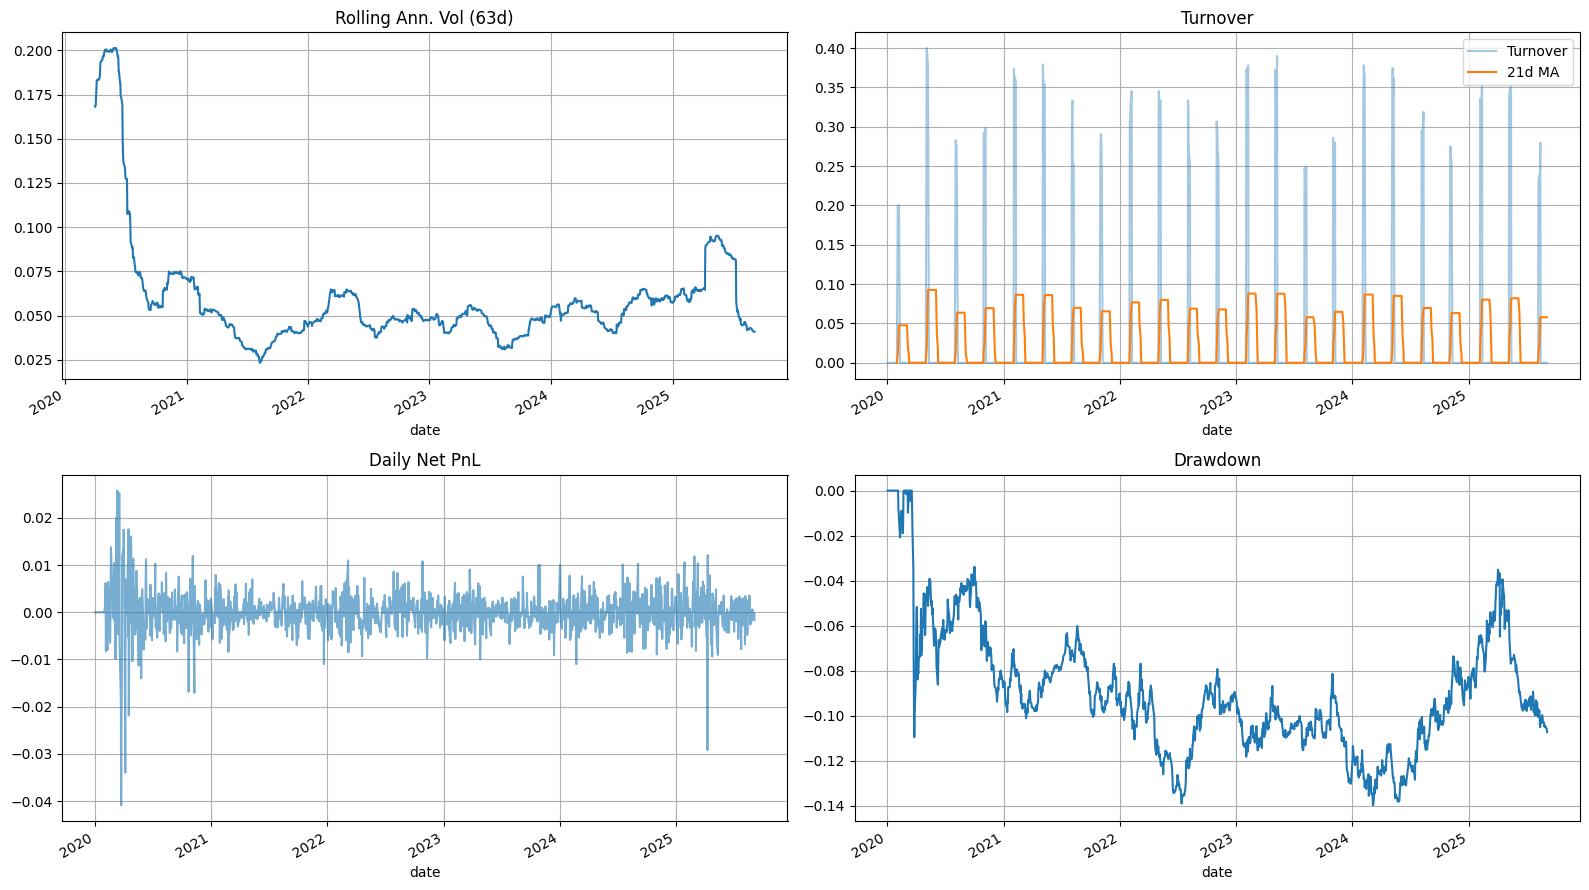

In [ ]:
# ============================== RISK ANALYSIS (NO FACTOR DATA) ==============================
def max_drawdown_duration(drawdown: pd.Series) -> int:
    under = drawdown < 0
    if not under.any():
        return 0
    runs = (under != under.shift()).cumsum()
    return int(under.groupby(runs).sum().max())

def var_es(series: pd.Series, alpha: float = 0.95) -> Tuple[float, float]:
    x = series.dropna().values
    if len(x) == 0:
        return np.nan, np.nan
    q = np.quantile(x, 1 - alpha)
    tail = x[x <= q]
    es = tail.mean() if len(tail) else np.nan
    return float(-q), float(-es)

def rolling_annualized_vol(series: pd.Series, window: int = 63, freq: int = 252) -> pd.Series:
    return series.rolling(window).std(ddof=0) * np.sqrt(freq)

def turnover_stats(W: pd.DataFrame) -> Dict[str, float]:
    t = W.diff().abs().sum(axis=1).fillna(0.0)
    return {
        "Turnover.mean": float(t.mean()),
        "Turnover.median": float(t.median()),
        "Turnover.p95": float(t.quantile(0.95)),
        "Turnover.max": float(t.max()),
    }

def plot_risk_panels(port_ret: pd.Series, drawdown: pd.Series, turnover: pd.Series, win_vol: int = 63):
    rv = rolling_annualized_vol(port_ret, window=win_vol, freq=RET_FREQ)

    plt.figure(figsize=(16,9))
    ax1 = plt.subplot(2,2,1)
    rv.plot(ax=ax1)
    ax1.set_title(f"Rolling Ann. Vol ({win_vol}d)")
    ax1.grid(True)

    ax2 = plt.subplot(2,2,2)
    turnover.plot(ax=ax2, alpha=.4, label="Turnover")
    turnover.rolling(21).mean().plot(ax=ax2, label="21d MA")
    ax2.legend(); ax2.set_title("Turnover"); ax2.grid(True)

    ax3 = plt.subplot(2,2,3)
    port_ret.plot(ax=ax3, alpha=.6)
    ax3.set_title("Daily Net PnL"); ax3.grid(True)

    ax4 = plt.subplot(2,2,4)
    drawdown.plot(ax=ax4)
    ax4.set_title("Drawdown"); ax4.grid(True)

    plt.tight_layout(); plt.show()

# Prepare series
port_ret = bt["net_pnl"].copy()
turn = bt["turnover"].copy()

# Core risk numbers
mdd = float(stats.get("MaxDD", np.nan))
calmar = float(stats.get("Calmar", np.nan))
ann_vol = float(stats.get("Ann.Vol", np.nan))
ann_ret = float(stats.get("Ann.Return", np.nan))
sharpe = float(stats.get("Sharpe", np.nan))
dur = max_drawdown_duration(dd)

var95, es95 = var_es(port_ret, 0.95)
var99, es99 = var_es(port_ret, 0.99)

tstats = turnover_stats(W)

print("\n=== Risk Summary (No Factors) ===")
print(f"Ann Return:            {ann_ret: .4f}")
print(f"Ann Vol:               {ann_vol: .4f}")
print(f"Sharpe:                {sharpe: .4f}")
print(f"Max Drawdown:          {mdd: .4f}")
print(f"Max DD Duration (d):   {dur}")
print(f"Calmar:                {calmar: .4f}")

print("\nVaR/ES (Historical, Daily)")
print(f"VaR 95%:               {var95: .4f}")
print(f"ES  95%:               {es95: .4f}")
print(f"VaR 99%:               {var99: .4f}")
print(f"ES  99%:               {es99: .4f}")

print("\nTurnover")
for k, v in tstats.items():
    print(f"{k:>18}: {v: .4f}")

# Plots
plot_risk_panels(port_ret, dd, turn, win_vol=63)
